# Objectives
The objective of this project is to develop a real-time weather prediction model using a stream learning approach with the River library. Specifically, we aim to predict whether the temperature will increase or decrease in the next 6 hours based on hourly weather data collected over around one year (2024-2025).

Weather prediction is a complex and dynamic task due to the continuous changes in atmospheric conditions. Using a stream learning approach allows the model to adapt to new patterns over time. Concept drift can occur between different seasons, where the changes in temperature follow different trends depending on the time of year.

Our main goal is to classify whether the temperature at a given time step will be higher or lower in 6 hours. This binary classification task will help in short-term weather forecasting, which is valuable for various sectors such as architecture or energy management.

The prediction is made using weather data from the current time step such as hummidity, pressure, or wind speed. Additionally, we also incorporate an engineered feature using the information from the three previous time steps. This feature represents the average temperature over the current and these three previous time steps. This approach provides the model with some contextual information.

In [1]:
# INSTALL OR BATCH LEARNING FAILS.
%pip install scikit-learn==1.5.2

Note: you may need to restart the kernel to use updated packages.


In [56]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift, stream

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score

# Load dataset

In [59]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")

# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df = df.drop(["Unnamed: 0","temp_diff_6h", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,rain.1h,target
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,Clouds,NaN,0
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,Clouds,NaN,0


# Descriptive analysis

Numerical features

In [60]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id", "target"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


Categorical features

In [72]:
df[['weather.id', "target"]] = df[['weather.id', "target"]].astype('category')
summary = df[['weather.id','target']].describe(include=['category']).transpose()
summary

,count,unique,top,freq
weather.id,8105,16,800,2190
target,8105,2,0,4576


Class distribution

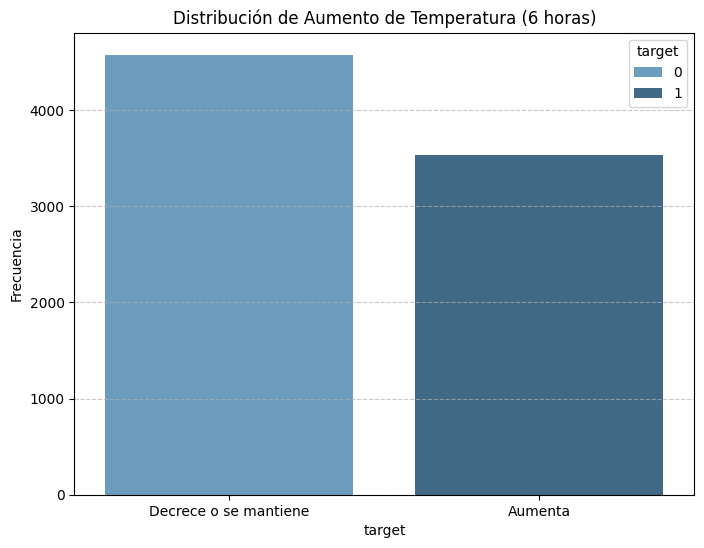

In [61]:
import seaborn as sns

# Class distribution of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Class distribution by time

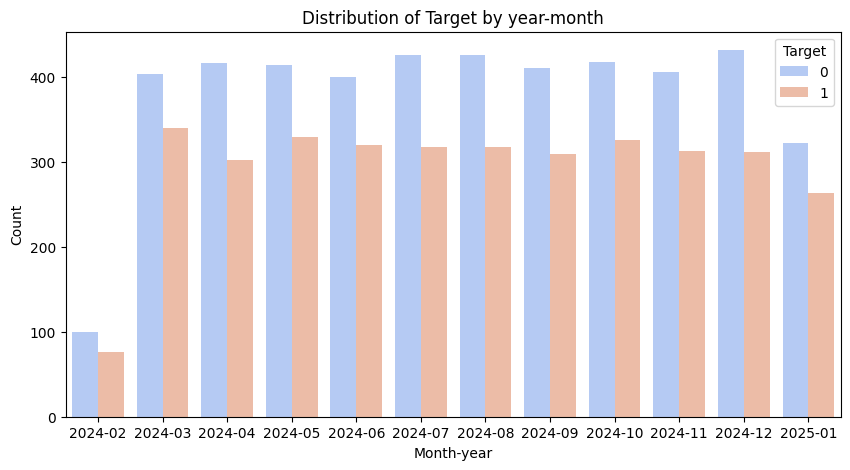

In [62]:
df_plot = copy.deepcopy(df)
df_plot["year_month"] = pd.to_datetime(df_plot["dt"], unit="s").dt.to_period("M")

# Class distribution by month year
plt.figure(figsize=(10, 5))
sns.countplot(data=df_plot, x="year_month", hue="target", palette="coolwarm")
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Train-test partition

In [73]:
# Last 1000 observations are reserved for the test set.
test_df = copy.deepcopy(df.tail(1000))
train_df = copy.deepcopy(df.iloc[:-1000])

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

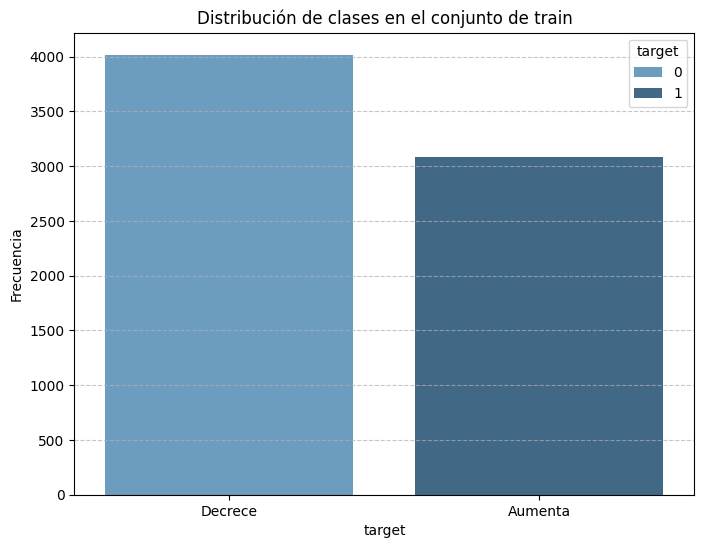

In [64]:
# Class distribution for train set
y_train_df = y_train.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_train_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de train")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

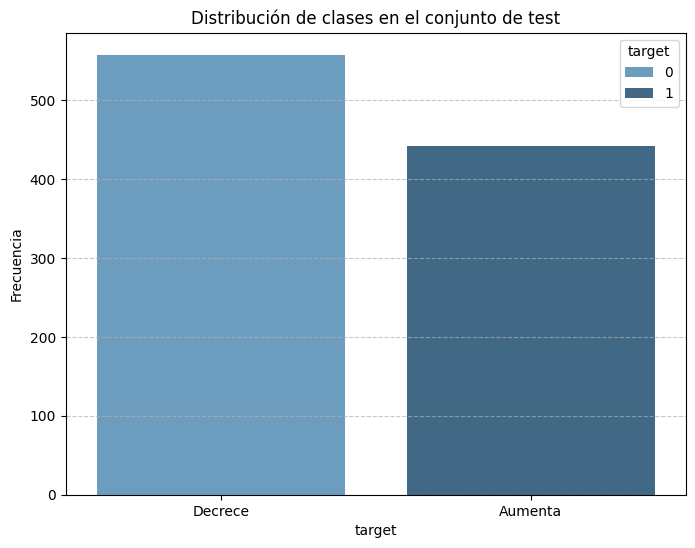

In [66]:
# Class distribution for test set.
y_test_df = y_test.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_test_df, palette="Blues_d")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases en el conjunto de test")
plt.xticks(ticks=[0, 1], labels=['Decrece', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Stream learning results

In [67]:
def create_features(modelo, wrapped=False, colIndex=None):
    """ 
    Creates a river pipeline with a specific preprocessing for given a model.

    Params:
        - modelo: River model to consider.
    """

    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h'
                  "year_month"]
    to_categoric = ["weather.main", "weather.id"]

    # the old attribute will be discarded, the new one hot encoded attribute will remain
    to_discard += to_categoric
    dt = "dt"
    
    # when using the river to sklearn wrapper the names of attributes are lost and replaced by their ordered numerical index
    # by mapping using the column index dict, we solve this problem
    if wrapped:
        cols_rolling = list(map(colIndex.get, cols_rolling))
        to_discard = list(map(colIndex.get, to_discard))
        to_categoric = list(map(colIndex.get, to_categoric))
        dt = colIndex[dt]

    def get_date_features(x):
        # likewise we must translate the attribute name "dt" to its ordered index in case of wrapping
        date = x[dt]
            
        date = pd.to_datetime(date, unit = "s")
        month =  date.month
        
        x['month'] = month
        return x

    model = compose.FuncTransformer(get_date_features)

    # pass categorical attribute to an online one hot encoding
    for att in to_categoric:
        model += (compose.Select(att) | preprocessing.OneHotEncoder(drop_zeros=False))
        
    model = compose.Discard(*to_discard)
    
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model

def stream_learning(X_train, y_train, X_test, y_test, modelo, drift_detect, model_name):

    """
    Obtains the results in train and test partition using a specific river pipeline.
    Concept drift is considered using a drift detector, which resets the model when
    a drift is detected.

    Params:
        - X_train: Dataframe with input features in training set.
        - y_train: Dataframe with target in training set.
        - X_test: Dataframe with input features in test set.
        - y_test: Dataframe with target in test set.
        - model: River pipeline to consider.
        - drift_detector: River drift detector to consider.
        - model_name: Name of the model to consider.
    """

    # Lists to store concept drift indexes and accuracy over time
    drifts = []
    ROC_values = []

    # Intialize model, drift detector and metrics
    drift_detector = copy.deepcopy(drift_detect)
    model = copy.deepcopy(modelo)
    ROC = metrics.ROCAUC()
    report2 = metrics.ClassificationReport()

    counter = 0

    # Concatenate X_train and X_test as in stream learning 
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)

    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change in {model_name} detected at index {counter}')
            # Store position where drift was detected
            drifts.append(counter)
            # Reset model
            model = copy.deepcopy(modelo)
            # Reset drift detector
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        drift_detector.update(yi)

        if y_pred != None:
            if counter % 100 == 0 and counter!=0:
                report2.update(yi, y_pred)
                ROC.update(yi, y_pred)
                # Save metric over time
                ROC_values.append(ROC.get())
            counter += 1
            
    return ROC_values, drifts, report2

def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector):
    
    """
    Store the results for a model over train and test sets.

    Params:
    - X_train: Dataframe with input features in training set.
    - y_train: Dataframe with target in training set.
    - X_test: Dataframe with input features in test set.
    - y_test: Dataframe with target in test set.
    - model: River model to consider.
    - drift_detector: River drift detector to consider.
    """

    ROCs = []
    drifts = []
    reports = []

    for model in models:
        model_name = model.__class__.__name__
        model_instance = create_features(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test,
                                                                       modelo=model_instance, drift_detect=drift_detector,
                                                                       model_name=model_name)
        
        ROCs.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    print("\n")
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("ROC-AUC:", float(round(ROCs[i][-1],4)))
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return ROCs, drifts, reports

def plot_roc(ROC_list, drifts, colors, labels, title, index_test):
    """
    Plots the results of the model with a detector, visualizing the metrics 
    and concept drift points over time.

    Params:
    - roc_list: List with values of a metric for each model.
    - drifts: List with the detected drifts for each model.
    """

    for i, ROC_values in enumerate(ROC_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(ROC_values))
        indices = indices*100
        plt.plot(indices, ROC_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--')

    plt.axvline(x=index_test, color="red", linestyle='-', label = "Test set start")

    plt.legend()
    plt.xlabel('Data instances processed')
    plt.ylabel('ROC-AUC')
    plt.title(title)
    plt.show()



Results for LogisticRegression:
ROC-AUC: 0.896
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      89.58%   93.48%   91.49%        46  
       1      90.91%   85.71%   88.24%        35  
                                                  
   Macro      90.25%   89.60%   89.86%            
   Micro      90.12%   90.12%   90.12%            
Weighted      90.16%   90.12%   90.08%            

                 90.12% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.6811
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      78.95%   61.22%   68.97%        49  
       1      55.81%   75.00%   64.00%        32  
                                                  
   Macro      67.38%   68.11%   66.48%            
   Micro      66.67%   66.67%   66.67%            
Weighted      69.81%   66.67%   67.00%   

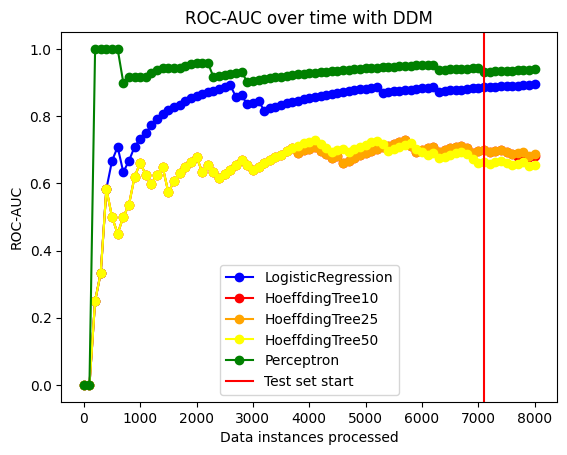

In [68]:
# Define parameters of the experiment.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]

# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.DDM(warm_start=100))
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with DDM", index_test = len(X_train)+1)

Change in LogisticRegression detected at index 264
Change in LogisticRegression detected at index 500
Change in LogisticRegression detected at index 837
Change in HoeffdingTreeClassifier detected at index 263
Change in HoeffdingTreeClassifier detected at index 498
Change in HoeffdingTreeClassifier detected at index 834
Change in HoeffdingTreeClassifier detected at index 263
Change in HoeffdingTreeClassifier detected at index 498
Change in HoeffdingTreeClassifier detected at index 834
Change in HoeffdingTreeClassifier detected at index 263
Change in HoeffdingTreeClassifier detected at index 498
Change in HoeffdingTreeClassifier detected at index 834
Change in Perceptron detected at index 264
Change in Perceptron detected at index 500
Change in Perceptron detected at index 837


Results for LogisticRegression:
ROC-AUC: 0.8137
Drifts: [264, 500, 837]
Report:            Precision   Recall   F1       Support  
                                                  
       0      80.77%   91.30% 

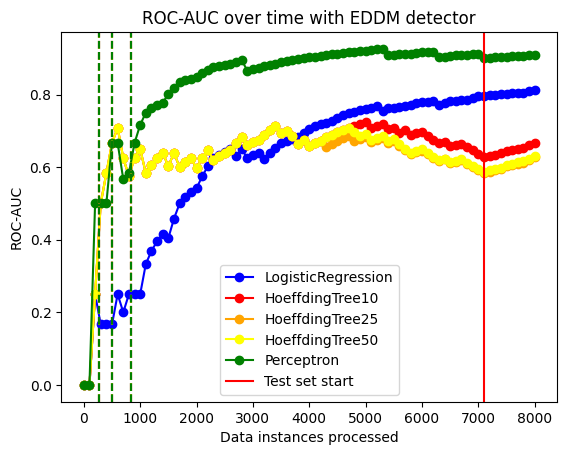

In [69]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector= drift.binary.EDDM(warm_start=100))
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with EDDM detector", index_test = len(X_train)+1)

# Batch learning results

In [77]:
def get_sklearn_results(X_train, y_train, X_test, y_test, models, labels, colIndex):
    
    # Cross-validation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score)

    for i, model in enumerate(models):

        # Create river pipeline and convert to sklearn
        river_pipeline = create_features(model, wrapped=True, colIndex=colIndex)
        sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)

        # Print cross-validation and test results for each model
        print(f"Results for {labels[i]}:")
        scores = cross_val_score(sk_pipeline, X_train, y_train, scoring=scorer, cv=cv)
        print(f'Cross-validation train ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')
        sk_pipeline.fit(X_train, y_train)
        y_pred = sk_pipeline.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test, y_pred)
        print(f'Test partition ROC AUC: {test_score:.4f} \n')

In [76]:
colIndex = {v: k for k, v in enumerate(X_train.columns)}
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]

get_sklearn_results(X_train, y_train, X_test, y_test, models, labels, colIndex)

Results for LogisticRegression:
Cross-validation train ROC AUC: 0.6624 (± 0.0101)
Test partition ROC AUC: 0.7425 

Results for HoeffdingTree10:
Cross-validation train ROC AUC: 0.6524 (± 0.0562)
Test partition ROC AUC: 0.7440 

Results for HoeffdingTree25:
Cross-validation train ROC AUC: 0.6949 (± 0.0121)
Test partition ROC AUC: 0.6058 

Results for HoeffdingTree50:
Cross-validation train ROC AUC: 0.6922 (± 0.0139)
Test partition ROC AUC: 0.6057 

Results for Perceptron:
Cross-validation train ROC AUC: 0.4711 (± 0.0413)
Test partition ROC AUC: 0.4065 

